# K-Nearest Neighbor (KNN): Brute-force

## Index

1. [Setup](#[1]-Setup)
2. [Data Analysis](#[2]-Data-Analysis)
3. [Implement KNN Algorithm](#[3]-Implement-KNN-Algorithm)
4. [Testing Model](#[4]-Testing-Model)
5. [Hyperparameter Tuning](#[5]-Hyperparameter-Tuning)

### Objective

1. Understanding KNN algorithm.
2. **Implement KNN** algorithm without scikit-learn.
3. Given a query point <code>x<sub>q</sub></code>, **predict** its class using KNN.
4. Implement **Estimator (Accuracy/Error)** for KNN algorithm.
5. Implement **RandomizedSearchCV** for KNN algorithm without scikit-learn.

<a id="#[1]-Setup"></a>
# [1] Setup

### Import and configure required libraries

In [1]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Data visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# Data modeling Libraries
import sklearn as sk
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# General imports
import math
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

# Library versions used in below EDA.
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)
print("Scikit-Learn version:", sk.__version__)

# Configure NumPy.
# Set `Line width` to Maximum 130 characters in the output, post which it will continue in next line.
np.set_printoptions(linewidth=130)

# Configure Pandas.
# Set display width to maximum 130 characters in the output, post which it will continue in next line.
pd.options.display.width = 130

# Configure Seaborn.
sns.set_style("whitegrid")  # Set white background with grid.
sns.set_palette("deep")  # Set color palette.
sns.set_context("paper", font_scale=1.5)  # Set font to scale 1.5 more than normal.

NumPy version: 1.21.5
Pandas version: 1.4.2
Matplotlib version: 3.5.1
Seaborn version: 0.11.2
Scikit-Learn version: 1.0.2


#### Common functions

In [2]:
def is_empty(element) -> bool:
    """
    Function to check if input `element` is empty.

    Other than some special exclusions and inclusions,
    this function returns boolean result of Falsy check.
    """
    if (isinstance(element, int) or isinstance(element, float)) and element == 0:
        # Exclude 0 and 0.0 from the Falsy set.
        return False
    elif isinstance(element, str) and len(element.strip()) == 0:
        # Include string with only one or more empty space(s) into Falsy set.
        return True
    elif isinstance(element, bool):
        # Exclude False from the Falsy set.
        return False
    else:
        # Falsy check.
        return False if element else True


def all_zeros(numbers):
    """
    Function to check if all elements in the list are zero.
    """
    return all(n == 0 for n in numbers)


def groupby_count(items, get_key):
    """
    Function to count `key` in a list of items.
    """
    count = {}
    for index, item in enumerate(items):
        key_name = get_key(item)
        if is_empty(key_name):
            raise ValueError(f"Specified key: `{key_name}` not found in the item at index: `{index}` in the list.")

        count[key_name] = count.get(key_name, 0) + 1

    return count


ENABLE_LOG = False


def title(title_str, padding=[1, 1], line_style="="):
    """
    Function to print() input string with some styles, when logging is enabled.
    """
    if ENABLE_LOG is True:
        pad_top, pad_bot = padding
        pt = "\n" * pad_top
        pb = "\n" * pad_bot
        print(pt + title_str + "\n" + line_style * len(title_str) + pb)


def text(*args):
    """
    Function to print() input string when logging is enabled.
    """
    if ENABLE_LOG is True:
        print(*args)


print("Loading common functions done!")

Loading common functions done!


### Generate data-points using `sklearn`

In [3]:
x, y = make_classification(
    n_samples=2350,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_clusters_per_class=1,
    random_state=60,
)

X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

<a href="#[2]-Data-Analysis"></a>
# [2] Data Analysis

In [4]:
ENABLE_LOG = True

title("Features")
text("Features shape:", x.shape)

title("Class Labels")
text("Class-labels shape:", y.shape)
(cl1, cl2), (cl1_count, cl2_count) = np.unique(y, return_counts=True)
text(f"Class 1: '{cl1}', Count:", cl1_count)
text(f"Class 2: '{cl2}', Count:", cl2_count)

f1_max = math.ceil(np.max(x[:, 0]))
f1_min = math.floor(np.min(x[:, 0]))
title("Feature 1")
text("Max value:", f1_max, "\nMin value:", f1_min)

f2_max = math.ceil(np.max(x[:, 1]))
f2_min = math.floor(np.min(x[:, 1]))
title("Feature 2")
text("Max value:", f2_max, "\nMin value:", f2_min)

title("Training Dataset")
text("Features shape:", X_train.shape)
text("Class-labels shape:", y_train.shape)

title("Training Dataset")
text("Features shape:", X_test.shape)
text("Class-labels shape:", y_test.shape)


Features

Features shape: (2350, 2)

Class Labels

Class-labels shape: (2350,)
Class 1: '0', Count: 1177
Class 2: '1', Count: 1173

Feature 1

Max value: 3 
Min value: -6

Feature 2

Max value: 4 
Min value: -4

Training Dataset

Features shape: (1762, 2)
Class-labels shape: (1762,)

Training Dataset

Features shape: (588, 2)
Class-labels shape: (588,)


**Dataset is almost Balanced!**

### Plot data-points

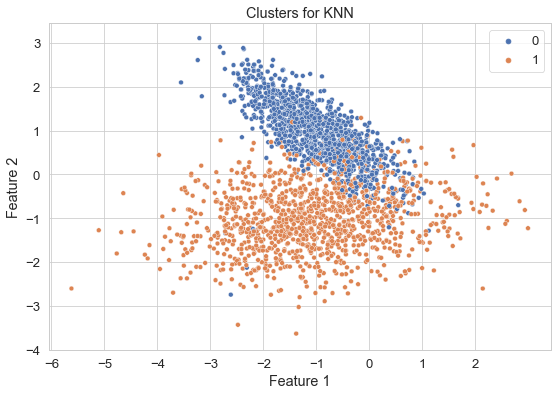

In [5]:
plt.figure(figsize=(9, 6))  # Width, Height

sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=y)
plt.title("Clusters for KNN")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.xticks(ticks=np.arange(f1_min, f1_max, 1))
plt.yticks(ticks=np.arange(f2_min, f2_max, 1))

plt.show()

<a id="#[3]-Implement-KNN-Algorithm"></a>
# [3] Implement KNN Algorithm

1. `D` := Represents entire dataset 
2. `n` := Total number of data-points.
3. `d` := Total number of features.
4. `x_q` := Query Point.

* **STEP 1:** Find `K` nearest points to <code>x<sub>q</sub></code> in `D`.
    * For each data-point <code>x<sub>i</sub></code> in `D` calculate the distance between <code>x<sub>q</sub></code> and <code>x<sub>i</sub></code>.
    * Sort the data-points in increasing order of their distance from <code>x<sub>q</sub></code>.
    * Say `k = 3` and take first three nearest points and store it in `knn`, for example `knn = {x5, x2, x7}`.
* **STEP 2:** Take majority vote of class-labels.
    * Get class-labels of all data-points in `knn` from _STEP 1_ and store it in `y_p`, for example `y_p = {y5, y2, y7}`.
    * Take class-label with highest occurrence in `y_p` and store it in `y_q`.
    * Declare <code>x<sub>q</sub></code> belongs to class `y_q`.

> **Note:**
> 1. If there are equal number of points from all the classes in `y`, it can create confusion while voting.
> 2. To avoid confusion in voting, `K` should preferably be **odd number**.
> 3. Its considered good practice to take `K` value as $\sqrt{N)}$.

There are different techniques available to calculate distance between two points:

1. Euclidean Distance: : The L2 Norm
2. Manhattan Distance: The L1 Norm
2. Minkowski Distance: Lp Norm, where p > 0
3. Hamming Distance
4. Cosine Distance

In [6]:
def cosine_similarity(p1, p2):
    """
    Function to compute Cosine Distance between two points.
    """
    if all_zeros(p1) or all_zeros(p2):
        return 0

    dot_prod = (p1[0] * p2[0]) + (p1[1] * p2[1])
    p1_mag = math.sqrt(p1[0] ** 2 + p1[1] ** 2)
    p2_mag = math.sqrt(p2[0] ** 2 + p2[1] ** 2)

    return dot_prod / (p1_mag * p2_mag)


# Function to compute Cosine Distance between two points.
cosine_distance = lambda p1, p2: 1 - cosine_similarity(p1, p2)

# Function to compute Manhattan Distance between tow points.
manhattan_distance = lambda p1, p2: abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])


def minkowski_distance(p1, p2, p=3):
    """
    Function to compute Euclidean Distance between two points.
    """
    diff = abs(p1[0] - p2[0]) ** p + abs(p1[1] - p2[1]) ** p
    return math.pow(diff, 1 / p)


# Function to compute Euclidean Distance between two points.
euclidean_distance = lambda p1, p2: minkowski_distance(p1, p2, p=2)

### Implementation

In [7]:
def KNNClassifier(X, Y):
    """
    Function to prepare training and testing data before applying KNN algorithm.
    """

    # Default values
    DFLT_K = 5
    DIST_ALGO = 1
    PRECISION = 6

    def get_k_nearest_points(X, x_q, K=DFLT_K, algo_type=DIST_ALGO):
        """
        Closure to return `K` nearest data-points to query-point `x_q`.
        """
        if algo_type == 1:
            text("Computing Euclidean Distance.")
            algo = euclidean_distance
        elif algo_type == 2:
            text("Computing Manhattan Distance.")
            algo = manhattan_distance
        elif algo_type == 3:
            text("Computing Minkowski Distance.")
            algo = minkowski_distance
        elif algo_type == 4:
            text("Computing Cosine Distance.")
            algo = cosine_distance
        else:
            raise ValueError(f"Invalid `algo_type` {algo_type}. Value should be in {1, 2, 3, 4}.")

        distances = []
        for idx, x in enumerate(X):
            label = str(Y[idx])
            distance = round(algo(x, x_q), PRECISION)
            distances.append([label, distance])

        text(f"Returning {K} nearest neighbors.")
        return sorted(distances, key=lambda x: x[1])[:K]

    def majority_vote(knn):
        """
        Closure to take majority vote of class-labels.
        """
        if is_empty(knn):
            raise ValueError("Class list is empty.")

        # Get class-labels of all data-points and take majority vote/count.
        cl_count = groupby_count(knn, lambda n: n[0])
        text("Class-labels count:", cl_count)

        # Sort class-labels by count.
        cl_sorted = sorted(cl_count.items(), key=lambda x: x[1], reverse=True)
        text("Class-labels sorted:", cl_sorted)

        # Return class-label with highest count as `y_q`.
        return cl_sorted[0]

    def predict(x_q, K=DFLT_K, algo_type=DIST_ALGO):
        """
        Closure to predict class-label based on `K` nearest neighbor.
        Apply KNN algorithm on query point `x_q` for given `K` value.
        """
        try:
            # STEP 1: Get K-nearest neighbors.
            knn = get_k_nearest_points(X, x_q, K, algo_type)

            # STEP 2: Get class with majority votes.
            return majority_vote(knn)  # Predicted class label and its votes

        except ValueError as err:
            print("Error:", err)

    return predict

<a id="#[4]-Testing-Model"></a>
# [4] Testing Model

In [8]:
ENABLE_LOG = True

predict = KNNClassifier(X_train, y_train)

pcl, nn = predict(x_q=(0.2, -0.6), K=50, algo_type=1)

print("\nPredicted class label:", pcl)
print("Nearest neighbors:", nn)

Computing Euclidean Distance.
Returning 50 nearest neighbors.
Class-labels count: {'0': 10, '1': 40}
Class-labels sorted: [('1', 40), ('0', 10)]

Predicted class label: 1
Nearest neighbors: 40


<a id="#[5]-Hyperparameter-Tuning"></a>
# [5] Hyperparameter Tuning

In [9]:
def knn_estimator(predict, X_test, y_test, K=5, error=False):
    """
    An Estimator is a function that returns accuracy score or error.
    """
    try:
        pcl_count = 0  # Correctly predicted class count.
        for idx, x_q in enumerate(X_test):  # Index, Query-point.
            acl = y_test[idx]  # Actual class label

            # Predicted class-label and its votes
            pcl, count = predict(x_q, K)

            # Compare prediction with actual class-label.
            if str(acl) == str(pcl):
                # Predicted class-label is same as actual class-label.
                pcl_count += 1

        accuracy = round(pcl_count / len(X_test), 4)
        # Return Training error if metric_type is `error` else return Accuracy.
        return 1 - accuracy if error else accuracy

    except ValueError as ve:
        print("Error:", ve)

### Why default `folds = 3`?

By splitting training dataset (`X_train`) into three folds, we can consider one of the fold with approximately **40% data-points as Cross-validation dataset** and remaining **60% data-points as Training dataset**.

In [10]:
from numpy import random


def knn_randomized_search_CV(ftrs, cls_lbls, K_range, folds=3, n_iter=10):
    """
    Function to implement RandomizedSearchCV for KNN algorithm.

    Following hyperparameters are randomized:
        1. K: Number of neighbors used in class-label voting.
        2. CV-dataset: Which Cross-validation dataset to pick after K-folding.
    """

    # Validations.
    if not n_iter > 0:
        raise ValueError("`n_iter` must be greater than zero.")

    k_min, k_max = K_range

    if n_iter > k_max:
        raise ValueError("Number of iterations cannot be greater than K-range.")

    # Generate random `n_iter` number of unique K values b/w [k_min, k_max + 1].
    K_vals = random.choice(range(k_min, k_max + 1), size=n_iter, replace=False)

    # Combine features and class-labels before folding.
    data_set = np.column_stack((ftrs, cls_lbls))

    # Split dataset into `folds` number of folds.
    splits = np.array_split(data_set, folds)
    text(f"Training dataset is split into {folds} folds.")

    k_folds = []
    for idx, split in enumerate(splits):
        # Delete the current split from the list of splits.
        rmng_splits = np.delete(splits, idx, axis=0)

        # Concatenate remaining splits into Training dataset.
        train = np.concatenate(rmng_splits, axis=0)

        # Use current split as Cross-Validation dataset.
        k_folds.append([train, split])  # Training dataset, CV dataset.

    def fit(estimator):
        """
        Closure to fit hyperparameters on Train and Cross-validation dataset.
        """
        trn_scrs = []
        tst_scrs = []

        p_bar = tqdm(np.sort(K_vals))  # Progress bar
        for K in p_bar:
            split_idx = random.randint(0, folds, 1).item()
            train, cv = k_folds[split_idx]

            # Prepare Training and Cross-validation dataset.
            X_train = train[:, 0:-1]
            y_train = train[:, -1]
            X_test = cv[:, 0:-1]
            y_test = cv[:, -1]

            predict = KNNClassifier(X_train, y_train)

            # Compute training error.
            p_bar.set_description(f"Estimating Training accuracy for K: {K}, using split #{split_idx}")
            trn_scrs.append(estimator(predict, X_train, y_train, K))

            # Compute testing error.
            p_bar.set_description(f"Estimating  Testing accuracy for K: {K}, using split #{split_idx}")
            tst_scrs.append(estimator(predict, X_test, y_test, K))

        return (trn_scrs, tst_scrs, K_vals)

    return fit

### Perform RandomizedSearchCV

In [11]:
ENABLE_LOG = False

# K_range is inclusive.
fit = knn_randomized_search_CV(X_train, y_train, K_range=(1, 25), folds=3, n_iter=25)
trn_scrs, tst_scrs, K_vals = fit(knn_estimator)

Estimating  Testing accuracy for K: 25, using split #2: 100%|██████████| 25/25 [02:32<00:00,  6.11s/it]


> Note: it takes around 3 minutes to complete!

### Plot Train-error vs Test-error

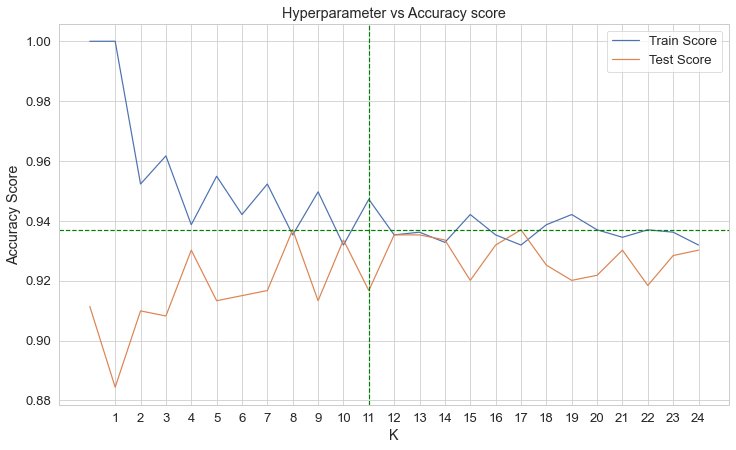

In [12]:
plt.figure(figsize=(12, 7))

sns.lineplot(data=trn_scrs, label="Train Score")
sns.lineplot(data=tst_scrs, label="Test Score")
plt.title("Hyperparameter vs Accuracy score")
plt.xlabel("K")
plt.ylabel("Accuracy Score")
plt.xticks(ticks=range(1, 25))
plt.axhline(max(tst_scrs), linestyle="--", color="g")

K = np.sort(K_vals)[np.argmin(trn_scrs)]
plt.axvline(K, linestyle="--", color="g")
plt.legend()

plt.show()